# Data Cleaning project
A pre-EDA step.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import pathlib
pathlib.Path().absolute()

WindowsPath('C:/Users/rafal.klat/Jupyters/DataCleaning')

In [86]:
df = pd.read_csv('dataset.csv')
# OGARNĄĆ I OPISAĆ ŹRÓDŁO
# https://www.quora.com/Where-can-I-get-messy-data-to-work-on-data-cleaning-skills

In [107]:
# df.drop(labels=['Unique Project ID'], axis=1, inplace=True)
# df.to_csv('dataset.csv')
# df.drop(labels=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'], axis=1, inplace=True)
# df.rename(columns={'Agency Code':'Agency ID'}, inplace=True)
df

,Investment ID,Business Case ID,Agency ID,Agency Name,Investment Title,Project ID,Agency Project ID,Project Name,Project Description,Start Date,Completion Date (B1),Planned Project Completion Date (B2),Projected/Actual Project Completion Date (B2),Planned Cost ($ M),Projected/Actual Cost ($ M),Updated Date,Updated Time
0,005-000001723,212,5.0,Department of Agriculture,AMS Infrastructure WAN and DMZ (AMSWAN),656.0,NaN,Operations,Annual Agency Operations.,01/10/2011,2012-30-09,NaN,NaN,15.297000,15.297000,22/09/2011,10:22:25
1,005-000001723,212,5.0,Department of Agriculture,AMS Infrastructure WAN and DMZ (AMSWAN),657.0,NaN,Virtualization,Program Areas will migrate their data over to ...,01/10/2011,31/03/2012,31/03/2012,31/03/2012,0.179000,0.179000,30/11/2011,06:09:57
2,005-000001723,212,5.0,Department of Agriculture,AMS Infrastructure WAN and DMZ (AMSWAN),658.0,NaN,Refresh,Programs Areas will replace 1/3 of their compu...,01/04/2012,30/09/2012,NaN,NaN,1.460000,1.460000,28/10/2011,05:50:19
3,005-000001822,213,5.0,Department of Agriculture,APHIS Electronic Permits System (ePermits),661.0,NaN,ePermits O&M FY11 Part 1.,"Production Support including Analysis, Softwar...",01/04/2011,30/09/2011,30/09/2011,30/09/2011,1.820500,1.456400,31/05/2012,14:20:11
4,005-000001822,213,5.0,Department of Agriculture,APHIS Electronic Permits System (ePermits),662.0,NaN,ePermits O&M FY12 Part 1,"Production Support including Analysis, Softwar...",01/04/2012,30/09/2012,30/09/2012,30/09/2012,1.713000,1.713000,31/05/2012,14:20:11
5,005-000001822,213,5.0,Department of Agriculture,APHIS Electronic Permits System (ePermits),663.0,NaN,ePermits O&M FY12 Part 2,"Production Support including Analysis, Softwar...",01/10/2012,31/03/2013,NaN,NaN,1.450000,1.450000,31/05/2012,14:20:11
6,005-000001822,213,5.0,Department of Agriculture,APHIS Electronic Permits System (ePermits),664.0,NaN,BRS Field Reports Phase 2,UAT Bug Fixes.,31/12/2010,31/03/2011,31/03/2011,31/03/2011,0.010000,0.010000,22/09/2011,10:34:24
7,005-000000038,214,5.0,Department of Agriculture,APHIS Enterprise Infrastructure,665.0,NaN,Enterprise Management,Management of APHIS Enterprise IT Systems.,01/10/2010,30/09/2011,30/09/2011,20/09/2011,46.960000,46.960000,22/09/2011,10:34:32
8,005-000000038,214,5.0,Department of Agriculture,APHIS Enterprise Infrastructure,666.0,NaN,VoIP Riverdale,Installation of voice over IP phones in Riverd...,15/08/2011,30/04/2012,30/04/2012,30/04/2012,0.662000,0.662000,31/05/2012,14:20:13
9,005-000000038,214,6.0,Department of Agriculture,APHIS Enterprise Infrastructure,667.0,NaN,Enterprise Security,Maintain Enterprise Security integrity.,06/09/2011,31/12/2012,NaN,NaN,0.572000,0.572000,01/08/2012,13:21:08


In [105]:
# df.rename(columns={'Unique Investment Identifier':'Investment ID'}, inplace=True)
df['Business Case ID'] = df['Business Case ID'].astype(int)
# indices_to_drop = df.loc[df['Business Case ID'].isna()].index
# df.drop(indices_to_drop, inplace=True)
# df['Business Case ID'].sort_values()
df.dtypes

Investment ID                                     object
Business Case ID                                   int32
Agency Code                                      float64
Agency Name                                       object
Investment Title                                  object
Project ID                                       float64
Agency Project ID                                 object
Project Name                                      object
Project Description                               object
Start Date                                        object
Completion Date (B1)                              object
Planned Project Completion Date (B2)              object
Projected/Actual Project Completion Date (B2)     object
Planned Cost ($ M)                               float64
Projected/Actual Cost ($ M)                      float64
Updated Date                                      object
Updated Time                                      object
dtype: object

In [83]:
print(len(df[['Unique Investment Identifier', 'Business Case ID']].drop_duplicates()))
print(len(df['Unique Investment Identifier'].unique()))
print(len(df['Business Case ID'].unique()))

600
600
600


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2494 entries, 0 to 2493
Data columns (total 20 columns):
Unnamed: 0                                       2494 non-null int64
Unnamed: 0.1                                     2494 non-null int64
Unique Investment Identifier                     2494 non-null object
Business Case ID                                 2468 non-null float64
Agency Code                                      2468 non-null float64
Agency Name                                      2468 non-null object
Investment Title                                 2468 non-null object
Project ID                                       2468 non-null float64
Agency Project ID                                1313 non-null object
Project Name                                     2468 non-null object
Project Description                              2468 non-null object
Start Date                                       2451 non-null object
Completion Date (B1)                             245

In [78]:
# There are rows with Totals. It doesn't add any value, but only complicates the analysis.
indices_to_drop = df.loc[df['Business Case ID'].isna()].index
df.drop(indices_to_drop, inplace=True)

2469

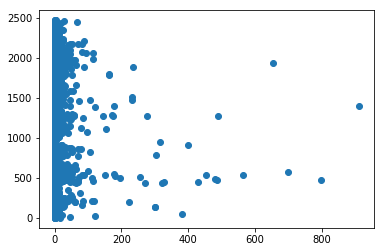

In [66]:
x = df[df['Projected/Actual Cost ($ M)']<1000]['Projected/Actual Cost ($ M)']
y = range(len(x))

# plt.hist(x, bins=100)
# plt.yscale('log')
plt.scatter(x,y)
len(x)

In [ ]:
# todo:

# Unique Investment Identifier - czy tam zawsze jest 005?
#Business Case ID, Agency Code, Project ID - wyglada, ze to moga byc inty
# Agency Name - moze to sa tylko departamenty?
# dates i times -> timestamps
# Cost Variance - dobre jednostki? 
# unique porojet id moze jako pierwsze/drugie?
# NaN -> None/null
# project name - powtarzaja sie, ale prawie (np. 3 i 4)
# inny index (któreś ID)
# project ID vs unique project ID
# czy w Agency Project ID cos w ogole jkest?
# ID vs Identifier
# 1 kolumna z unique ID nie jest unique


#sprawdzic unique values
# info() - tylko objects i float64
# describe()
# min i max


## Cleaning columns one by one
1. `Unique Investment Identifier`:
    1. Not unique, despite the name. It shouldn't be the first column, because it looks like Primary Key.
	2. **Identifier** could be **ID**.

In [ ]:
# Rename the column
df.rename(columns={'Unique Investment Identifier':'Investment ID'}, inplace=True)

2. `Business Case ID`
    1. It is float, but should be int.
    2. It corresponds 1:1 with `Investment ID`, so it should be kept in another lookup table.
    3. There are some `NInvestment IDaN` values. These are rows with totals and they should be removed - they don't add any value, but only complicate an analysis.

In [114]:
# Drop rows with totals
indices_to_drop = df.loc[df['Business Case ID'].isna()].index
df.drop(indices_to_drop, inplace=True)

# Change type to int
df['Business Case ID'] = df['Business Case ID'].astype(int)

# Save into another DF
business_case = pd.DataFrame(data=df[['Investment ID', 'Business Case ID']])
business_case.drop_duplicates(inplace=True)
business_case.set_index(keys='Investment ID', inplace=True)
business_case.to_csv('business_case.csv')

3. `Agency Code`
    1. **Code** could be **ID**.
	2. It is float, but should be int.

In [118]:
# Rename the column to `Agency ID`:
df.rename(columns={'Agency Code':'Agency ID'}, inplace=True)

# Change type to int
df['Agency ID'] = df['Agency ID'].astype(int)

4. `Agency Name`
	1. It corresponds 1:1 with `Agency Code`, so it should be kept in another lookup table. In fact there are only two cases in whole DataFrame, where `Agency ID` doesn't reflect `Agency Name` ideally. By comparing lengths of `Agency ID`, `Agency Name` and pair of these two, we see that there is **one more of unique entries** within Code+Name pair. By checking uniqueness we can conclude that value `6` is our point of pain. Two entries, which have wrong `Agency ID` values (not `Agency Name`, what can be easily deduced from other entries), should have `5`. 

In [133]:
# Define indices of rows to be changed
indices_to_change = df[(df['Agency ID'] == 6) & (df['Agency Name'] != 'Department of Commerce')].index

# Assign new values
for index in indices_to_change:
    df.at[index, 'Agency ID'] = 5

5. `Investment Title`
    1. There are some minor formatting problems (e.g. '&amp;' instead of '&'), hpwever they won't be touched, because these are long business names and could be defined and described somewhere else with whichever formatting.

6. `Project ID`
    1. It's a float, but should be an int.
	2. It's unique, so it should be the Primary Key and the first column in data set.

7. `Agency Project ID`
	1. Almost half of the values are NaN (but read by Pandas correctly). Since these are some IDs of internal use of agencies, they won't be touched.
	df[['Agency Name', 'Agency Project ID']][df['Agency Project ID'].isna()==False]
8. `Project Name`
	1. It corresponds with `Project ID`, so it should be kept in another lookup table.
9. `Project Description`
	1. It corresponds with `Project ID`, so it should be kept in another lookup table.
10. `Start Date`
	1. It's an object, but should be a date.
11. `Completion Date (B1)`
	1. It's an object, but should be a date.
	2. Multiple formats (`2012-30-09`, `31/03/2012`)
12. `Planned Project Completion Date (B2)`
	1. It's an object, but should be a date.
	2. Multiple formats (`2012-30-09`, `31/03/2012`)
13. `Projected/Actual Project Completion Date (B2)`
	1. It's an object, but should be a date.
	2. Multiple formats (`2012-30-09`, `31/03/2012`)
14. `Planned Cost ($ M)`
	1. 2459 out of 2494 (~98,5%) values are lower than 1000, the units better be Thousands, not Millions, to ease the analysis and interpretation.
15. `Projected/Actual Cost ($ M)`
	1. 2469 out of 2494 (~99%) values are lower than 1000, the units better be Thousands, not Millions, to ease the analysis and interpretation.
16. `Updated Date`
	1. Should be merged with `Update Time` as a timestamp.
17. `Updated Time`
	1. Should be merged with `Update Date` as a timestamp.

3. `Agency Code`
    1. **Code** could be **ID**.
	2. It is float, but should be int.

3. `Agency Code`
    1. **Code** could be **ID**.
	2. It is float, but should be int.